# Regularización 

# Ejercicios

In [1]:
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import uniform, norm

# Ejericio 0

Reproducir ~todas~ las figuras 6.4, 6.5, 6.6, 6.8 del `ISLR2`

## Ejercicio 1

Genere un conjunto de datos 
*   $f(x)=-2x^4+3x^2+1$
*   $x\sim Unif(0,1)$
*   $y=f(x) + \varepsilon$
*   $\varepsilon \sim \mathcal{N}(0,0.01)$

Realice un scatter plot y un ajuste lineal usando la covariable $x$ y un intercept.

In [2]:
def f(x):
    return - 2 * x**4 + 3 * x**2 + 1


n = 100  # Tamaño de muestra
sigma = 0.5
x = uniform.rvs(loc=0, scale=1, size=n)  # loc es el límite inferior, scale es el límite superior
eps = norm.rvs(loc=0, scale=sigma, size=n)  # loc(ation) es la media µ, scale es la dispersión \sigma
y = f(x) + eps

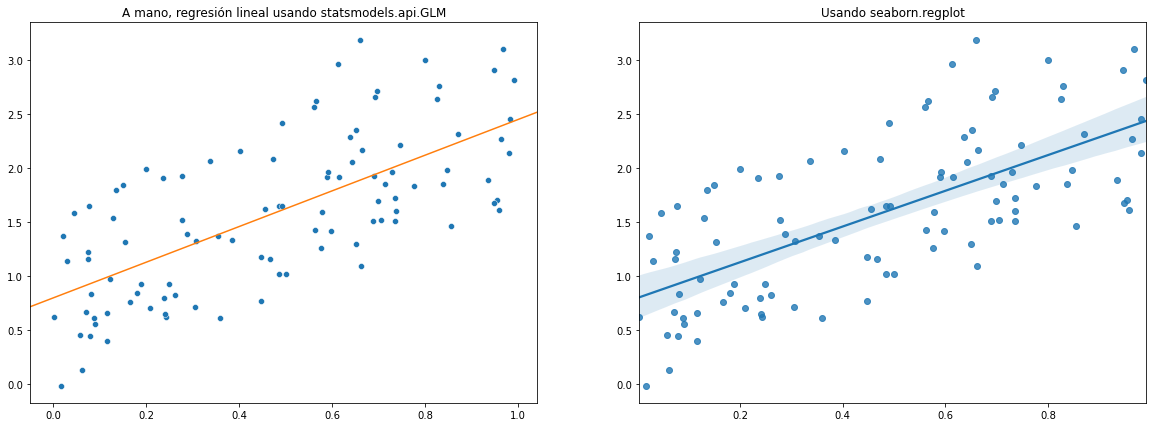

In [3]:
X = np.column_stack([np.ones_like(x), x])
fit = sm.GLM(endog=y, exog=X).fit()
intercept, slope = fit.params

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(x=x, y=y, ax=axs[0])
axs[0].axline(xy1=(0, intercept), slope=slope, color="C1")
axs[0].set_title("A mano, regresión lineal usando statsmodels.api.GLM")
sns.regplot(x=x, y=y, ax=axs[1])  # Pasar también los argumentos `ci=False, line_kws={"color": "C1"}` lo dejaría idéntico al otro.
axs[1].set_title("Usando seaborn.regplot")
plt.show()

## Ejercicio 2

Agregue como predictores los atributos polinómicos $x^2$, $x^3$, $x^4 \dots$ de manera secuencial:
* repita el ajuste lineal para cada modelo,
* grafique los ajustes obtenidos,
* grafique el error cuadrático medio en un conjunto de test en función del conjunto de predictores utilizado.
* extra: repita el punto anterior calculando el error de validación cruzada.

**Sugerencia:** considere el comando `poly`.

No hay comando `poly`, pero podemos armar una función que dado un vector $x$, cree una matriz de diseño $X$ con potencias hasta cierto frado `deg`, opcionalmente con un `intercept`.

Además, vamos a definir una utilidad mínima para calcular el error cuadrático medio, `mse`, e ir directo a calcular ambos ECM:
- el "global", entrenando y prediciendo sobre todo el conjunto de datos, y
- el de validación cruzada ("cv") sobre `num_folds` pliegos, definido como el promedio del ECM de los `num_folds` modelos entrenados.

In [4]:
def poly(x, deg, intercept=True):
    cols = []
    if intercept:
        cols.append(np.ones_like(x))
    cols.extend([x ** i for i in range(1, deg + 1)])
    return np.column_stack(cols)


def mse(x1, x2):
    return ((x1 - x2)**2).mean()


# Esta es una función muy boba para elegir correctamente la cantidad de subplots
def layout(n, cols=None, rows=None):
    from math import ceil
    if rows:
        return rows, ceil(n / rows)
    elif cols:
        return ceil(n / cols), cols
    else:
        raise TypeError("One of `cols, rows` keyword arguments must be passed.")

In [5]:
max_degree = 7
num_folds = 5

In [6]:
folds = np.random.choice(range(num_folds), size=n, replace=True)

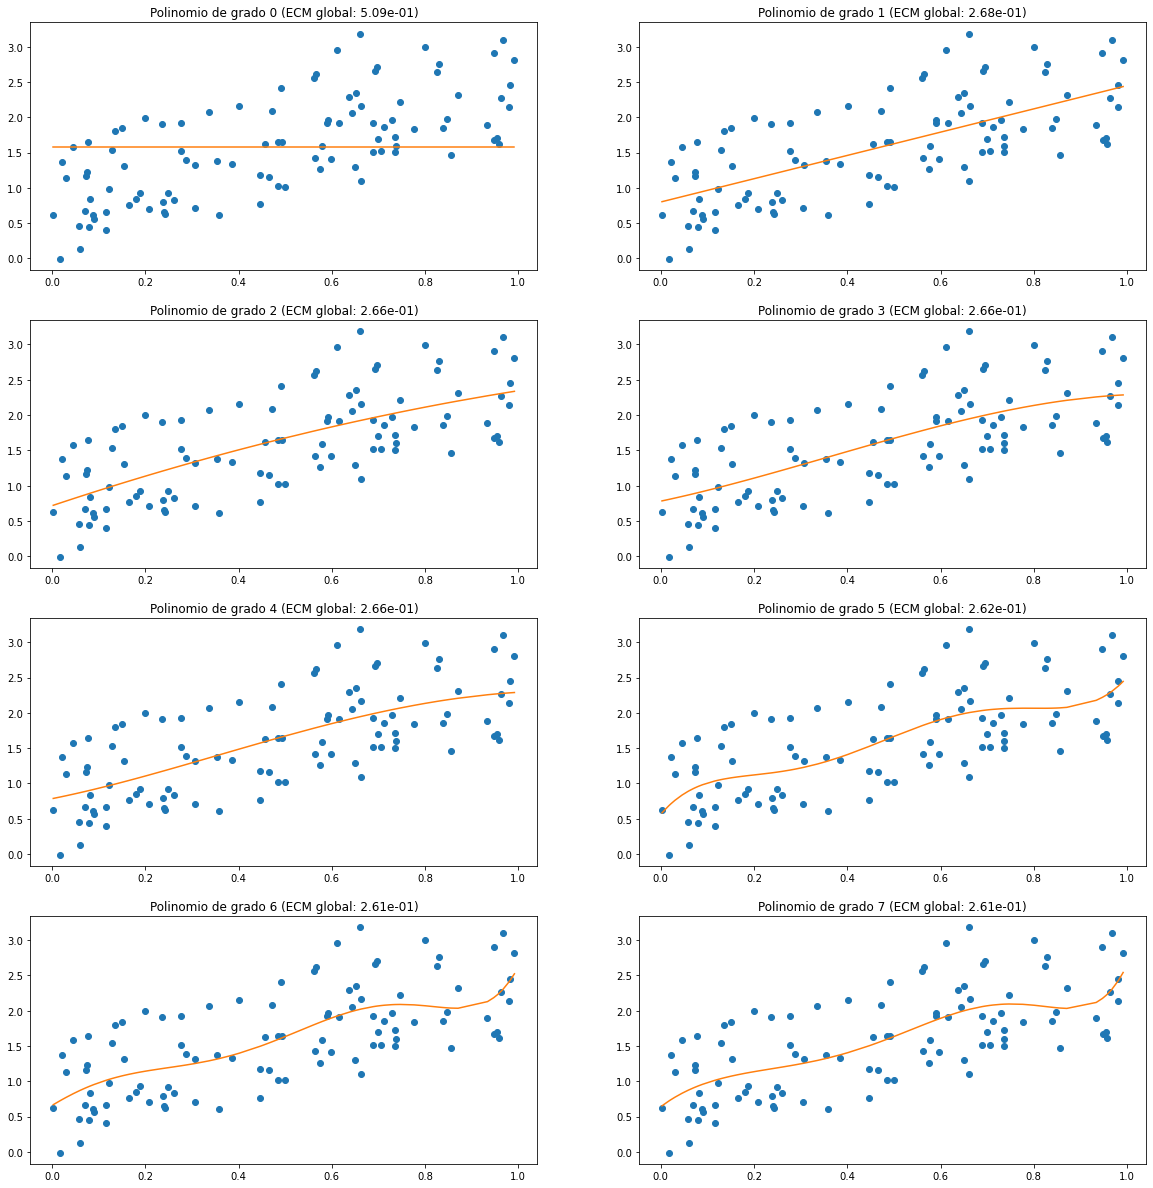

In [7]:
global_mse = np.zeros(max_degree + 1)
cv_mse = np.zeros(max_degree + 1)

ncols = 2
fig, axs = plt.subplots(
    *layout(max_degree + 1, cols=ncols),
    figsize=(20, 21),
)

for deg in range(max_degree + 1):
    ax = axs[deg // ncols, deg % ncols]  # Elijo el subplot a utilizar
    X = poly(x, deg)
    y_pred = sm.GLM(y, X).fit().predict()
    global_mse[deg] = mse(y, y_pred)
    ax.scatter(x=x, y=y)
    sns.lineplot(x=x, y=y_pred, ax=ax, color="C1")
    ax.set_title(f"Polinomio de grado {deg} (ECM global: {global_mse[deg]:.2e})")
    cv_mses = np.zeros(num_folds)
    for fold in range(num_folds):
        X_train, X_test = X[folds != fold], X[folds == fold]
        y_train, y_test = y[folds != fold], y[folds == fold]
        # Entreno con los datos de num_folds - 1 "pliegos", predigo en el pliego restante
        y_pred = sm.GLM(y_train, X_train).fit().predict(X_test)
        cv_mses[fold] = mse(y_test, y_pred)
    cv_mse[deg] = cv_mses.mean()

<AxesSubplot:>

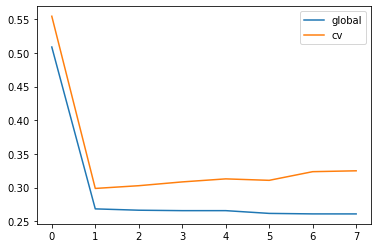

In [8]:
import pandas as pd
pd.DataFrame({"global": global_mse, "cv": cv_mse}).plot()

## Ejercicio 3

Repita las regresiones anteriores con una penalidad *ridge* y *lasso*. 
Grafique el error cuadrático medio en un conjunto de test para distintos valores de penalización.

**Sugerencia:** considere el comando `glmnet` cambiando su parámetro `alpha` y `cv.glmnet` para hallar el parámetro de penalización por validación cruzada.

In [9]:
from sklearn.linear_model import Lasso

Nos vamos a restringir al modelo cuártico para simplificar el análisis. Comenzamos por encontrar el $\alpha$ óptimo de _lasso_ dentro de una grilla predeterminada, usando la misma lógica del ejercicio anterior.

In [10]:
# Como los algoritmos de scikit-learn fitean el intercept por separado,
# no agregamos la columna de unos en la matriz de diseño X.
X = poly(x, 4, intercept=False)

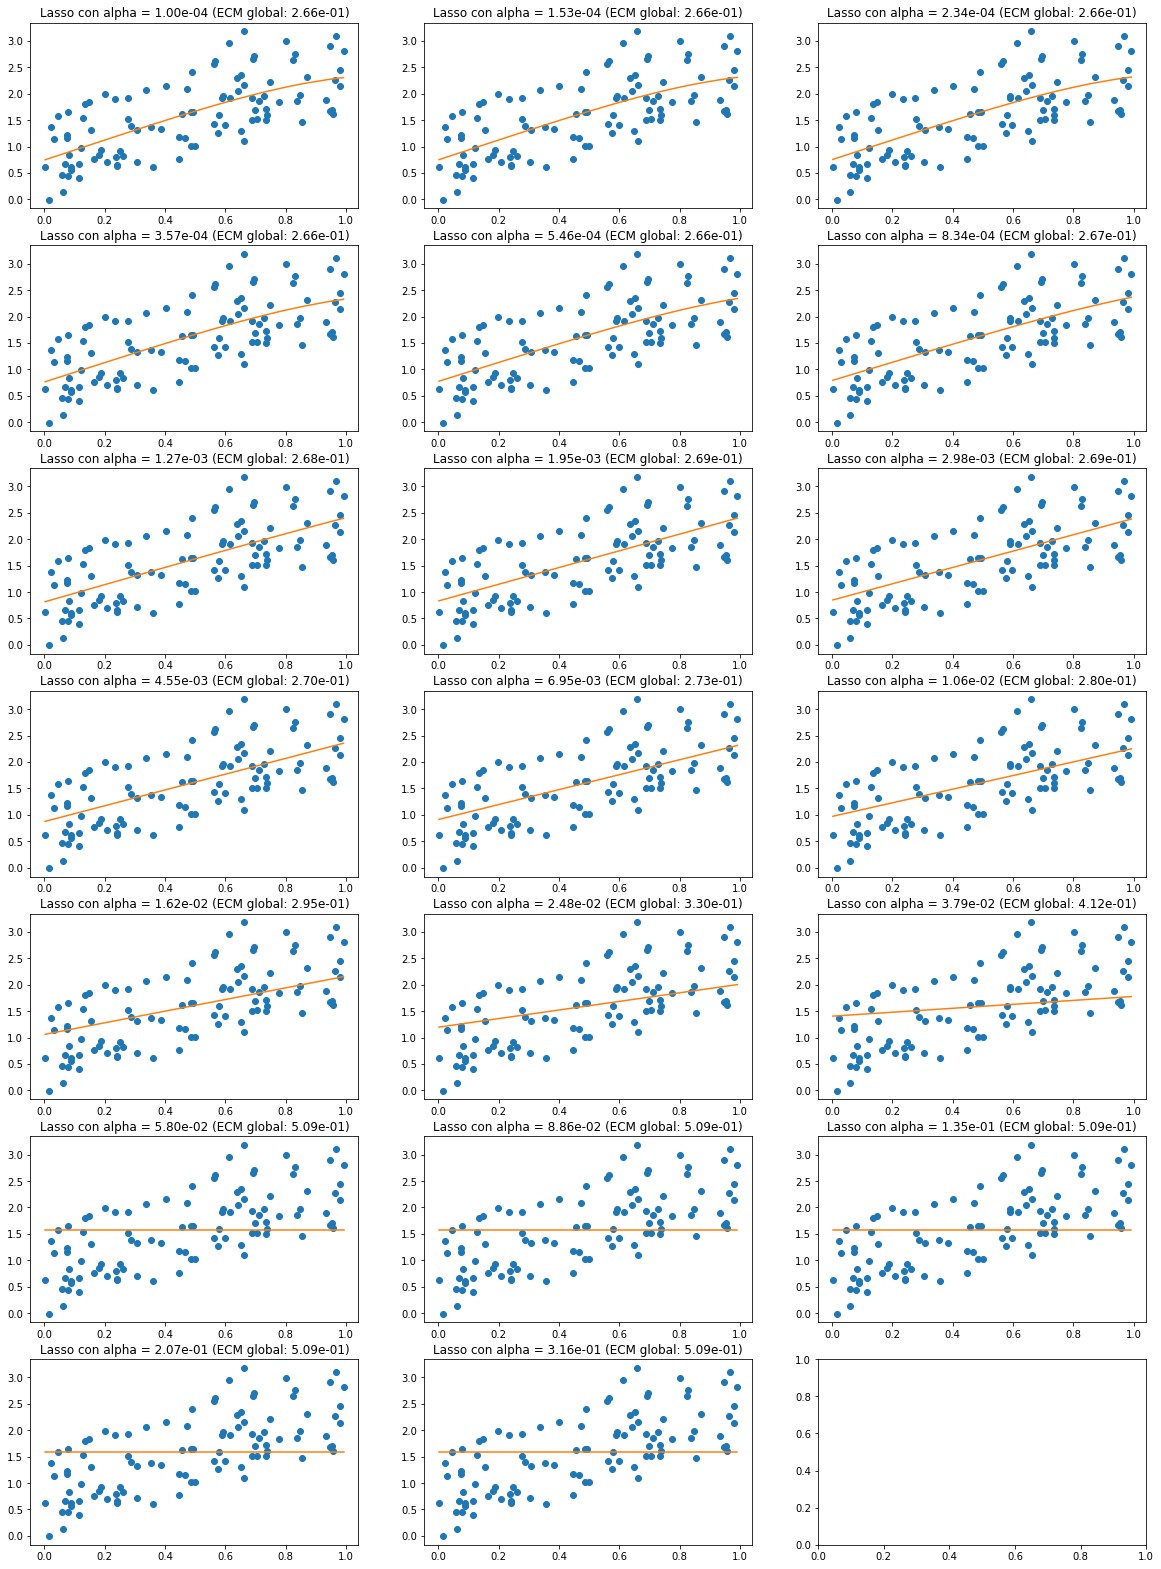

In [11]:
alphas = np.logspace(-4, -0.5, 20)
global_mse = np.zeros(len(alphas))
cv_mse = np.zeros(len(alphas))

ncols = 3
fig, axs = plt.subplots(
    *layout(len(alphas), cols=ncols),
    figsize=(20, 28),
)
    
for idx, a in enumerate(alphas):
    ax = axs[idx // ncols, idx % ncols]  # Elijo el subplot a utilizar
    lasso = Lasso(alpha=a, max_iter=10000, normalize=True)
    y_pred = lasso.fit(X, y).predict(X)
    global_mse[idx] = mse(y, y_pred)
    ax.scatter(x=x, y=y)
    sns.lineplot(x=x, y=y_pred, ax=ax, color="C1")
    ax.set_title(f"Lasso con alpha = {a:.2e} (ECM global: {global_mse[idx]:.2e})")
    cv_mses = np.zeros(num_folds)
    for fold in range(num_folds):
        X_train, X_test = X[folds != fold], X[folds == fold]
        y_train, y_test = y[folds != fold], y[folds == fold]
        # Entreno con los datos de num_folds - 1 "pliegos", predigo en el pliego restante
        y_pred = lasso.fit(X_train, y_train).predict(X_test)
        cv_mses[fold] = mse(y_test, y_pred)
    cv_mse[idx] = cv_mses.mean()

Aquí arriba, se ve con claridad cómo a medida que aumenta $\alpha$, el polinomio de predicciones se acerca más y más a una recta constante, que predice siempre la media global (recordemos que el intercept es el único término no penalizado).

El gráfico a continuación no es _exactamente_  "el error cuadrático medio en un conjunto de test para distintos valores de penalización" como pide el ejercicio, sino que es "el promedio de los ECM de test en los `num_folds` pliegos de CV, para distintos valores de penalización $\alpha$", que debería ser más representativos de la performance "real" del estimador.

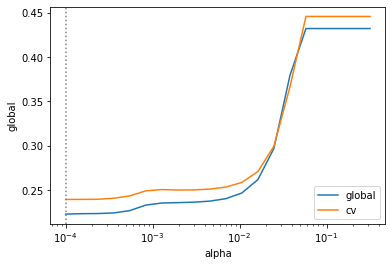

In [12]:
import pandas as pd
cv_lasso = pd.DataFrame({"global": global_mse, "cv": cv_mse, "alpha": alphas})
sns.lineplot(x="alpha", y="global", data=cv_lasso, label="global")
sns.lineplot(x="alpha", y="cv", data=cv_lasso, label="cv")
plt.axvline(cv_lasso.alpha[np.argmin(cv_lasso.cv.values)], linestyle="dotted", color="gray")
plt.xscale("log")

In [13]:
cv_lasso.alpha[np.argmin(cv_lasso.cv.values)]

0.0001

Elegir $\alpha$ por validación cruzada es una operación tan común, que `scikit-learn` ofrece una clase que hace _exactamente_ eso, `LassoCV`

In [14]:
from sklearn.linear_model import LassoCV

De la documentación de `LassoCV`, vemos que hay varias formas de especificar la validación cruzada, _via_ el parámetro `cv`
```
cv : int, cross-validation generator or iterable, default=None
    Determines the cross-validation splitting strategy.
    Possible inputs for cv are:

    - None, to use the default 5-fold cross-validation,
    - int, to specify the number of folds.
    - :term:`CV splitter`,
    - An iterable yielding (train, test) splits as arrays of indices.
```

Esta última no es la más estándar (más común sería decirle que use $k\in\mathbb{N}$ pliegos), pero nos permite reproducir exactamente los pliegos que usamos antes, `folds`, con sólo escribir un iterador que los devuelva:

In [15]:
def folds_iter(folds):
    for i in np.unique(folds):
        yield np.where(folds != i)[0], np.where(folds == i)[0]

In [16]:
lassocv = LassoCV(alphas=alphas, max_iter=10000, cv=folds_iter(folds), normalize=True)

In [17]:
lassocv.fit(X, y)
lassocv.alpha_, lassocv.coef_

/home/gonzalo/workfiles/lab/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038295967777415285, tolerance: 0.003383913679947081
  model = cd_fast.enet_coordinate_descent_gram(
/home/gonzalo/workfiles/lab/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005882729839518319, tolerance: 0.0034029609202867457
  model = cd_fast.enet_coordinate_descent_gram(


(0.0001, array([-0.2070846 ,  3.59740041,  0.        , -2.28840892]))

¡El mismo $\alpha$ que encontramos a mano! Excelente noticia; de aquí en más, podemos usar la clase "estándar", `LassoCV` y confiar ciegamente en sus resultados.

Eso sí, nótese que el $\alpha$ óptimo puede variar bastante dependiendo de cómo se armen los pliegos de CV:

In [18]:
lassocv = LassoCV(alphas=alphas, max_iter=10000, cv=5, normalize=True)

In [19]:
lassocv.fit(X, y)
lassocv.alpha_, lassocv.coef_

(0.00015283067326587687,
 array([-0.        ,  3.22011901,  0.        , -2.07537524]))

Ahora, intentemos elegir un estimador "óptimo" entre las siguientes tres estrategias regularización para la regresión lineal:
- sin penalizar,
- con penalidad _ridge_, y
- con penalidad _lasso_.

Definiremos primero los conjuntos de train y test, que serán compartidos por los tres estimadores para la selección final: cada uno entrenará sobre `train`, y elegiremos "el mejor" modelo, evaluándolos a todos en la data de `test`. Para Ridge y Lasso, tendremos que volver a subdividir el conjunto de entrenamiento en $K$ pliegos, y con ellos elegir la penalidad óptima por CV.

In [20]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear = LinearRegression().fit(X_train, y_train)
lasso = LassoCV(cv=5, maxiter=10000).fit(X_train, y_train)  # No especifico la lista de `alphas` a considerar, dejo que la clase se encargue
ridge = RidgeCV(cv=5).fit(X_train, y_train)

ValueError: could not convert string to float: 'N'

In [22]:
{algo: mse(y_test, eval(algo).predict(X_test)) for algo in ["linear", "lasso", "ridge"]}

{'linear': 0.3446347733302906,
 'lasso': 0.36636957055149816,
 'ridge': 0.36088412065316994}

_De entre los algoritmos e hiperparámetors considerados_, la regresión lineal parece ser la mejor, aunque no por mucho.

# Ejercicio 4

Para el conjunto de datos `Hitters` del paquete `ISRL2`, grafique los coeficientes estimados por cuadrados mínimos, ridge y lasso. Verifique las propiedades de *shrinkage*.

**Sugerencia:** descarte los datos faltantes con el comando `na.omit`.

Para hacer una comparación directa con el código equivalente en R, vamos a seguir la sección 6.5 del ISLR2, de manera un poco idiosincrática.

In [58]:
hitters = pd.read_csv("hitters.csv")

In [60]:
hitters.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

Las variables categóricas (`League, Division, NewLeague`) no las manipulan automáticamente la mayoríá de los modelos (de `scikit-learn` y otros), así que hay que transformarlas en dummies.

Una alternativa es hacerlo manualmente, otra es hacerlo con `Transformers` de `scikit-learn`, que luego se pueden integrar en Pipelines, y una tercera es usar `statsmodels.formula.api` para [fitear modelos usando fórmulas estilo R](https://www.statsmodels.org/dev/example_formulas.html), que puede ser una transición interesante al stack de Python desde R.

Aquí usaremos Transformers, de manera crecientemente compleja (un `OneHotEncoder` suelto, el mismo OHE dentro de un `ColumnTransformer` y finalmente un ColumnTransformer componiendo un Pipeline que termine en el estimador de interés.

In [61]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [62]:
hitters.shape, sum(hitters.Salary.isna())

((322, 20), 59)

In [63]:
hitters = hitters.dropna()
# tip: nunca uses `dropna=True` para modificar un dataframe inplace.
# Es muy peligroso y lleva a comportamientos misteriosos.
hitters.shape, sum(hitters.Salary.isna())

((263, 20), 0)

In [64]:
X = hitters.drop(columns="Salary")
y = hitters.Salary

In [82]:
grid = np.logspace(10, -2, num=100)

In [107]:
def l1_norm(vec):
    return np.abs(vec).sum()


def l2_norm(vec):
    return np.sqrt((vec ** 2).sum())

In [115]:
l1_norm(np.array([0.1, 0.2]))

0.30000000000000004

In [83]:
ridge = RidgeCV(alphas=grid).fit(X, y)

ValueError: could not convert string to float: 'N'

In [84]:
categorical_features = hitters.columns[hitters.dtypes == "O"].tolist()
# Alternativamente,
# categorical_features = hitters.select_dtypes(include=object).columns.tolist()

In [85]:
categorical_features

['League', 'Division', 'NewLeague']

In [86]:
enc = OneHotEncoder(sparse=False).fit(hitters[categorical_features])
enc.transform(hitters[categorical_features])

array([[0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 0., 1.],
       ...,
       [1., 0., 0., 1., 1., 0.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 1., 0.]])

In [87]:
enc.get_feature_names(categorical_features)

array(['League_A', 'League_N', 'Division_E', 'Division_W', 'NewLeague_A',
       'NewLeague_N'], dtype=object)

In [88]:
pd.DataFrame(
    enc.transform(hitters[categorical_features]),
    columns=enc.get_feature_names(categorical_features)
).astype(int)

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
0,0,1,0,1,0,1
1,1,0,0,1,1,0
2,0,1,1,0,0,1
3,0,1,1,0,0,1
4,1,0,0,1,1,0
...,...,...,...,...,...,...
258,0,1,1,0,0,1
259,1,0,1,0,1,0
260,1,0,0,1,1,0
261,1,0,1,0,1,0


In [94]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough",
)

In [95]:
preprocessor.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['League', 'Division', 'NewLeague'])])

In [96]:
preprocessor.transform(X)

array([[1.000e+00, 1.000e+00, 1.000e+00, ..., 6.320e+02, 4.300e+01,
        1.000e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 8.800e+02, 8.200e+01,
        1.400e+01],
       [1.000e+00, 0.000e+00, 1.000e+00, ..., 2.000e+02, 1.100e+01,
        3.000e+00],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 3.700e+01, 1.130e+02,
        7.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.314e+03, 1.310e+02,
        1.200e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 4.080e+02, 4.000e+00,
        3.000e+00]])

In [97]:
preprocessor.get_feature_names()

['cat__x0_N',
 'cat__x1_W',
 'cat__x2_N',
 'AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors']

In [179]:
X_proc = preprocessor.transform(X)

In [169]:
from sklearn.linear_model import Ridge, Lasso

In [307]:
ridge_coefs = np.zeros((len(grid), X_proc.shape[1]))
lasso_coefs = np.zeros((len(grid), X_proc.shape[1]))
normalize = False
for idx, a in enumerate(grid):
    fit = Ridge(alpha=a, normalize=normalize).fit(X_proc, y)
    ridge_coefs[idx] = fit.coef_
    fit = Lasso(alpha=a, normalize=normalize, max_iter=10000).fit(X_proc, y)
    lasso_coefs[idx] = fit.coef_

In [308]:
lr_coef = LinearRegression().fit(X_proc, y).coef_

In [309]:
norms = pd.DataFrame(
    data={
        "ridge_l1": np.apply_along_axis(l1_norm, 1, ridge_coefs),
        "ridge_l2": np.apply_along_axis(l2_norm, 1, ridge_coefs),
        "lasso_l1": np.apply_along_axis(l1_norm, 1, lasso_coefs),
        "lasso_l2": np.apply_along_axis(l2_norm, 1, lasso_coefs),
    },
    index=grid,
)

In [310]:
long = norms.reset_index().rename(
    columns={"index": "alfa"}
).melt(id_vars="alfa", value_name="metric")

long["method"], long["norm"] = zip(*long.variable.str.split("_"))

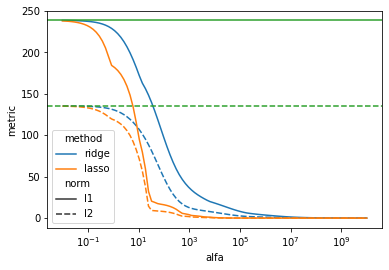

In [311]:
sns.lineplot(x="alfa", y="metric", hue="method", style="norm", data=long)
plt.axhline(l1_norm(lr_coef), color="C2", linestyle="solid", label="linreg")
plt.axhline(l2_norm(lr_coef), color="C2", linestyle="dashed", label="linreg")
plt.xscale("log")
# plt.yscale("log")

In [312]:
categorical_features, preprocessor.get_feature_names()

(['League', 'Division', 'NewLeague'],
 ['cat__x0_N',
  'cat__x1_W',
  'cat__x2_N',
  'AtBat',
  'Hits',
  'HmRun',
  'Runs',
  'RBI',
  'Walks',
  'Years',
  'CAtBat',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'PutOuts',
  'Assists',
  'Errors'])

In [313]:
idx = 49
(
    grid[idx],
    pd.Series(ridge_coefs[idx],  preprocessor.get_feature_names()),
    norms["ridge_l2"].iat[idx],
)

(11497.569953977356,
 cat__x0_N    0.243137
 cat__x1_W   -0.641849
 cat__x2_N    0.176155
 AtBat       -1.450236
 Hits         4.595472
 HmRun       -0.136532
 Runs         0.512760
 RBI          0.552869
 Walks        4.081512
 Years       -0.029546
 CAtBat      -0.270344
 CHits        0.552178
 CHmRun       0.182395
 CRuns        1.166593
 CRBI         0.645267
 CWalks      -0.516468
 PutOuts      0.293650
 Assists      0.323220
 Errors      -1.217486
 dtype: float64,
 6.715562738164301)

In [314]:
idx = 59
(
    grid[idx],
    pd.Series(ridge_coefs[idx],  preprocessor.get_feature_names()),
    norms["ridge_l2"].iat[idx],
)

(705.4802310718645,
 cat__x0_N    3.415623
 cat__x1_W   -9.410539
 cat__x2_N    2.383552
 AtBat       -2.105153
 Hits         7.341676
 HmRun        1.492129
 Runs        -1.598315
 RBI          0.147765
 Walks        5.876327
 Years       -1.130728
 CAtBat      -0.192227
 CHits        0.154844
 CHmRun      -0.093996
 CRuns        1.530183
 CRBI         0.752808
 CWalks      -0.760428
 PutOuts      0.293998
 Assists      0.375527
 Errors      -2.653453
 dtype: float64,
 14.68587955636149)

In [305]:
grid[49], pd.Series(ridge_coefs[49],  preprocessor.get_feature_names()), norms["ridge_l2"].iat[49]

(705.4802310718645,
 array([-0.017, -0.245, -0.003,  0.002,  0.006,  0.025,  0.01 ,  0.011,
         0.013,  0.053,  0.   ,  0.001,  0.004,  0.001,  0.001,  0.001,
         0.001,  0.   , -0.001]),
 0.25325649510969334)

¡Se verifica el shrinkage! A valores de $\alpha$ muy pequños, las normas $L_1,\ L_2$ de los 3 métodos coinciden. A medida que se agranda $\alpha$, las normas del vector de coeficientes de Ridge y Lasso disminuye.
Pareciera ser que tanto en Ridge y Lasso ambas normas decrecen con $\alpha$, y que la norma $L_2$ se reduce más que la $L_1$ con ambos algoritmos.

# Estandarización ([fuente](h?ttps://statisticaloddsandends.wordpress.com/2018/11/15/a-deep-dive-into-glmnet-standardize/))

In [ ]:

n <- 100; p <- 5; true_p <- 2
set.seed(950)
X <- matrix(rnorm(n * p), nrow = n)
beta <- matrix(c(rep(1, true_p), rep(0, p - true_p)), ncol = 1)
y <- X %*% beta + 3 * rnorm(n)

In [ ]:
X_centered <- apply(X, 2, function(x) x - mean(x))
Xs <- apply(X_centered, 2, function(x) x / sqrt(sum(x^2) / n))

In [ ]:

minstall.packages("glmnet")
invisible(library(glmnet))
fit <- glmnet(Xs, y, standardize = TRUE)
fit2 <- glmnet(Xs, y, standardize = FALSE)
fit3 <- glmnet(X, y, standardize = TRUE)

In [ ]:
sum(fit$lambda != fit2$lambda)
# 0
max(abs(fit$beta - fit2$beta))
# 6.661338e-16

Para cada columna j, nuestras variables estandarizadas son $Z_j=\frac{X_j-\mu_j}{s_j}$ donde $\mu_j$ u $s_j$ son la media y desvío estándar de la columna $j$ respectivamente. Si $\beta_j$ y $\gamma_j$ representan los coeficientes de los modelos fit2 y fit3 respectivamente entonces tenemos que

$$\beta_0 + \sum_{j=1}^p \beta_j Z_j = \gamma_0 + \sum_{j=1}^p \gamma_j X_j$$ 

Reemplazamos $Z_j$,
$$\beta_0 + \sum_{j=1}^p \beta_j \frac{X_j-\mu_j}{s_j} = \gamma_0 + \sum_{j=1}^p 
\gamma_j X_j$$ 

Acomodamos,
$$\left (\beta_0 - \sum_{j=1}^p \frac{\mu_j\beta_j}{s_j} \right ) + \sum_{j=1}^p  \frac{\beta_j}{s_j} X_j = \gamma_0 + \sum_{j=1}^p 
\gamma_j X_j$$ 

Es decir,
$$\gamma_0 = \beta_0 - \sum_{j=1}^p \frac{\mu_j\beta_j}{s_j}$$ 
y 
$$\gamma_j=\frac{\beta_j}{s_j}$$ para $j=1,\dots,p$.

In [ ]:
# Medias y desvíos por columna
X_mean <- colMeans(X)
X_sd <- apply(X_centered, 2, function(x) sqrt(sum(x^2) / n))
 
# Diferencia entre intercepts
fit2_int <- coefficients(fit2)[1,]
fit3_int <- coefficients(fit3)[1,]
temp <- fit2_int - colSums(diag(X_mean / X_sd) %*% fit2$beta)
max(abs(temp - fit3_int))
# 1.110223e-16
 
# Diferencia entre coeficientes de predictores
temp <- diag(1 / X_sd) %*% fit2$beta
max(abs(temp - fit3$beta))
# 1.110223e-15

La discusión anterior fue sobre la estandarización de $x$. ¿Qué pasa con la estandarización de $y$? La documentación señala que cuando `family = "gaussian"`, $y$ se estandariza automáticamente, y los coeficientes no se estandarizan al final del procedimiento.

Sean $\mu_y$ y $s_y$ la media y desvío estándar de $y$ respectivamente. Si el ajuste con $y$ estandarizada da coeficientes $\beta_0$ y $\beta_1,\dots,\beta_p$ entonces sin estandarizar debería dar como intercept $\mu_y + s_y \beta_0$ y coeficientes $s_y \beta_1, \dots s_y \beta_p$.

In [ ]:
# Media y desvío de y
y_mean <- mean(y)
y_sd <- sqrt(sum((y - y_mean)^2) / n)
 
# Ajuste estandarizando
fit4 <- glmnet(X, (y - y_mean) / y_sd, standardize = TRUE)
 
# Diferencia de intercepts
fit4_int <- coefficients(fit4)[1,]
temp <- fit4_int * y_sd + y_mean
max(abs(temp - fit3_int))
# 1.110223e-16
 
# Diferencia de coeficientes
max(abs(y_sd * fit4$beta - fit3$beta))
# 8.881784e-16

# Validación cruzada [(fuente)](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)

In [ ]:
set.seed(42)     # fijamos la semilla por reproducibilidad
library(glmnet)  # ridge y lasso
invisible(library(dplyr))   # escalar los datos
library(psych)   # traza de una matriz

data("mtcars")
# Centramos la y, las X las centra glmnet
y <- mtcars %>% select(mpg) %>% scale(center = TRUE, scale = FALSE) %>% as.matrix()
X <- mtcars %>% select(-mpg) %>% as.matrix()

# 10-CV para elegir lambda
lambdas_to_try <- 10^seq(-3, 5, length.out = 100)
# Con alpha = 0 implementa ridge
ridge_cv <- cv.glmnet(X, y, alpha = 0, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)
# Resultados de validación cruzada
plot(ridge_cv)

In [ ]:
# Mejor cv-lambda
lambda_cv <- ridge_cv$lambda.min
# Ajuste del modelo final y su R2
model_cv <- glmnet(X, y, alpha = 0, lambda = lambda_cv, standardize = TRUE)
y_hat_cv <- predict(model_cv, X)
ssr_cv <- t(y - y_hat_cv) %*% (y - y_hat_cv)
rsq_ridge_cv <- cor(y, y_hat_cv)^2

# Criterios de información para elegir lambda
X_scaled <- scale(X)
aic <- c()
bic <- c()
for (lambda in seq(lambdas_to_try)) {
  # Ajustamos el modelo
  model <- glmnet(X, y, alpha = 0, lambda = lambdas_to_try[lambda], standardize = TRUE)
  # Coeficientes y residuos (sacamos el intercept)
  betas <- as.vector((as.matrix(coef(model))[-1, ]))
  resid <- y - (X_scaled %*% betas)
  # Calculamos los grados de libertad efectivos
  ld <- lambdas_to_try[lambda] * diag(ncol(X_scaled))
  H <- X_scaled %*% solve(t(X_scaled) %*% X_scaled + ld) %*% t(X_scaled)
  df <- tr(H)
  # Calculamos los criterios de información
  aic[lambda] <- nrow(X_scaled) * log(t(resid) %*% resid) + 2 * df
  bic[lambda] <- nrow(X_scaled) * log(t(resid) %*% resid) + 2 * df * log(nrow(X_scaled))
}

In [ ]:
# Mejores lambdas criteriosos
lambda_aic <- lambdas_to_try[which.min(aic)]
lambda_bic <- lambdas_to_try[which.min(bic)]

# Ajustes finales y R2
model_aic <- glmnet(X, y, alpha = 0, lambda = lambda_aic, standardize = TRUE)
y_hat_aic <- predict(model_aic, X)
ssr_aic <- t(y - y_hat_aic) %*% (y - y_hat_aic)
rsq_ridge_aic <- cor(y, y_hat_aic)^2

model_bic <- glmnet(X, y, alpha = 0, lambda = lambda_bic, standardize = TRUE)
y_hat_bic <- predict(model_bic, X)
ssr_bic <- t(y - y_hat_bic) %*% (y - y_hat_bic)
rsq_ridge_bic <- cor(y, y_hat_bic)^2

# Aumentar lambda achica los coeficientes
res <- glmnet(X, y, alpha = 0, lambda = lambdas_to_try, standardize = FALSE)
plot(res, xvar = "lambda")
legend("bottomright", lwd = 1, col = 1:6, legend = colnames(X), cex = .7)

## Lasso

In [ ]:
# Perform 10-fold cross-validation to select lambda ---------------------------
lambdas_to_try <- 10^seq(-3, 5, length.out = 100)
# Setting alpha = 1 implements lasso regression
lasso_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)
# Plot cross-validation results
plot(lasso_cv)

In [ ]:
# Best cross-validated lambda
lambda_cv <- lasso_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv <- glmnet(X, y, alpha = 1, lambda = lambda_cv, standardize = TRUE)
y_hat_cv <- predict(model_cv, X)
ssr_cv <- t(y - y_hat_cv) %*% (y - y_hat_cv)
rsq_lasso_cv <- cor(y, y_hat_cv)^2


# See how increasing lambda shrinks the coefficients --------------------------
# Each line shows coefficients for one variables, for different lambdas.
# The higher the lambda, the more the coefficients are shrinked towards zero.
res <- glmnet(X, y, alpha = 1, lambda = lambdas_to_try, standardize = FALSE)
plot(res, xvar = "lambda")
legend("bottomright", lwd = 1, col = 1:6, legend = colnames(X), cex = .7)

# Ejemplo Bateadores

**Fuente:** Sección 6.5.2 (ISLR2)


In [ ]:
library(glmnet)
library(ISLR2)

Hitters <- na.omit(Hitters)
x = model.matrix(Salary ~ ., Hitters)[, -1]
y = Hitters$Salary

In [ ]:
grid <- 10^seq (10, -2, length = 100)
ridge.mod <- glmnet(x, y, alpha = 0, lambda = grid)

In [ ]:
set.seed(1)
train <- sample (1:nrow(x) , nrow(x)/2)
test <- (-train)
y.test <- y[test]

In [ ]:
fit = lm(y[train] ~ x[train, ])

In [ ]:
ridge.mod <- glmnet(x[train, ] , y[train], alpha = 0, lambda = grid, thresh = 1e-12)
ridge.pred <- predict(ridge.mod, s = 4 , newx = x[test, ])
mean((ridge.pred - y.test )^2)

In [ ]:
set.seed(1)
cv.out_ridge <- cv.glmnet(x[train,] , y[train], alpha = 0)
#plot ( cv . out )
bestlam_ridge <- cv.out_ridge$lambda.min
ridge.pred <- predict(ridge.mod, s = bestlam_ridge, newx = x[test, ])
mse_ridge = mean((ridge.pred - y.test)^2)
best_ridge = glmnet(x[train,], y[train], alpha=0, lambda=bestlam)

In [ ]:
set.seed (1)
lasso.mod <- glmnet(x[train, ] , y[train] , alpha = 1, lambda = grid)
cv.out_lasso <- cv.glmnet(x[train, ], y[train], alpha = 1)
#plot(cv.out)
bestlam_lasso <- cv.out_lasso$lambda.min
lasso.pred <- predict(lasso.mod, s = bestlam_lasso, newx = x[test, ])
mean((lasso.pred - y.test) ^2)
best_lasso = glmnet(x[train,], y[train], alpha=1, lambda=bestlam_lasso)

In [ ]:
plot(coef(fit)[-1], xaxt="n", xlab="", ylab="coeficientes", pch = 16, cex=2)
abline(v=xtick, col = "gray80")
lines(coef(best_lasso)[-1], col = "orange", lwd = 3)
lines(coef(best_ridge)[-1], col = "skyblue3", lwd = 3)
xtick <- 1:(length(coef(fit))-1)
axis(side=1, at=xtick, labels = colnames(x), las = 2)

# Interpretación bayesiana [(fuente)](https://rpubs.com/lmorgan95/ISLR_CH6_Solutions)

## Lasso

La verosimilitud para la muestra es 
\begin{aligned}
    L(\theta \mid \beta)
    &= p(\beta \mid \theta) \\
    &= p(\beta_1 \mid \theta) \times \cdots \times p(\beta_n \mid \theta) \\
    &= \prod_{i = 1}^{n}
    p(\beta_i \mid \theta)
    \\
    &= \prod_{i = 1}^{n}
    \frac{
        1
    }{
        \sigma \sqrt{2\pi}
    }
    \exp
    \left(-
        \frac{
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        }{
            2\sigma^2
        }
    \right)
    \\
    &=
    \left(
        \frac{
            1
        }{
            \sigma \sqrt{2\pi}
        }
    \right)^n
    \exp
    \left(
        - \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
    \right)
\end{aligned}

Si tomamos como distribución a priori una doble exponencial (Laplace) con media 0 y mismo parámetro de escala

$$p(\beta) = \frac{1}{2b}\exp(- \lvert \beta \rvert / b)$$

reemplazamos en
$$f(\beta \mid X, Y) \propto f(Y \mid X, \beta) p(\beta \mid X) = f(Y \mid X, \beta) p(\beta)$$
y nos queda

\begin{aligned}
    f(Y \mid X, \beta)p(\beta)
    &=
    \left(
        \frac{
            1
        }{
            \sigma \sqrt{2\pi}
        }
    \right)^n
    \exp
    \left(
        - \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
    \right)
    \left(
        \frac{
            1
        }{
            2b
        }
        \exp(- \lvert \beta \rvert / b)
    \right)
    \\
    &=
    \left(
        \frac{
            1
        }{
            \sigma \sqrt{2\pi}
        }
    \right)^n
    \left(
        \frac{
            1
        }{
            2b
        }
    \right)
    \exp
    \left(
        - \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        -
        \frac{
            \lvert \beta \rvert
        }{
            b
            }
    \right)
\end{aligned}

Tomamos logaritmo:

\begin{aligned}
    \log
    f(Y \mid X, \beta)p(\beta)
    &=
    \log
    \left[
        \left(
            \frac{
                1
            }{
                \sigma \sqrt{2\pi}
            }
        \right)^n
        \left(
            \frac{
                1
            }{
                2b
            }
        \right)
        \exp
        \left(
            - \frac{
                1
            }{
                2\sigma^2
            }
            \sum_{i = 1}^{n}
            \left[
                Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
            \right]^2
            -
            \frac{
                \lvert \beta \rvert
            }{
                b
                }
        \right)
    \right]
    \\
    &=
    \log
    \left[
        \left(
            \frac{
                1
            }{
                \sigma \sqrt{2\pi}
            }
        \right)^n
        \left(
            \frac{
                1
            }{
                2b
            }
        \right)
    \right]
    -
    \left(
        \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \frac{
            \lvert \beta \rvert
        }{
            b
        }
    \right)
\end{aligned}

Buscamos valor que maximiza:

\begin{aligned}
    \arg\max_\beta \, f(\beta \mid X, Y)
    &=
    \arg\max_\beta
    \,
    \log
    \left[
        \left(
            \frac{
                1
            }{
                \sigma \sqrt{2\pi}
            }
        \right)^n
        \left(
            \frac{
                1
            }{
                2b
            }
        \right)
    \right]
    -
    \left(
        \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \frac{
            \lvert \beta \rvert
        }{
            b
            }
    \right)
    \\
\end{aligned}

Como el primer término no depende de $beta$ es equivalente:

\begin{aligned}
    &=
    \arg\min_\beta
    \,
    \frac{
        1
    }{
        2\sigma^2
    }
    \sum_{i = 1}^{n}
    \left[
        Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
    \right]^2
    +
    \frac{
        \lvert \beta \rvert
    }{
        b
    }
    \\
    &=
    \arg\min_\beta
    \,
    \frac{
        1
    }{
        2\sigma^2
    }
    \sum_{i = 1}^{n}
    \left[
        Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
    \right]^2
    +
    \frac{
        1
    }{
        b
    }
    \sum_{j = 1}^{p} \lvert \beta_j \rvert
    \\
    &=
    \arg\min_\beta
    \,
    \frac{
        1
    }{
        2\sigma^2
    }
    \left(
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \frac{
            2\sigma^2
        }{
            b
        }
        \sum_{j = 1}^{p} \lvert \beta_j \rvert
    \right)
\end{aligned}

Si poneos $\lambda = 2\sigma^2/b$ terminamos con 

\begin{aligned}
    &=
    \arg\min_\beta
    \,
    \sum_{i = 1}^{n}
    \left[
        Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
    \right]^2
    +
    \lambda
    \sum_{j = 1}^{p} \lvert \beta_j \rvert
    \\
    &=
    \arg\min_\beta
    \,
    \text{RSS}
    +
    \lambda
    \sum_{j = 1}^{p} \lvert \beta_j \rvert
\end{aligned}

que resulta ser la expresión del estimador lasso.

## Ridge


Consideramos ahora una distribución a prior normal de media $\theta$ y varianza $c$:


\begin{aligned}
    f(\beta \mid X, Y)
    \propto f(Y \mid X, \beta) p(\beta \mid X)
    = f(Y \mid X, \beta) p(\beta)
\end{aligned}

Our probability distribution function then becomes:

$$p(\beta)
        = \prod_{i = 1}^{p} p(\beta_i)
        = \prod_{i = 1}^{p}
        \frac{
            1
        }{
            \sqrt{
                2c\pi
            }
        }
        \exp \left(
            - \frac{
                \beta_i^2
                }{
                    2c
                }
        \right)
        = \left(
            \frac{
                1
            }{
                \sqrt{
                    2c\pi
                }
            }
        \right)^p
        \exp \left(
            - \frac{
                1
            }{
                2c
            }
            \sum_{i = 1}^{p} \beta_i^2
        \right)

Reemplazamos
\begin{aligned}
    f(Y \mid X, \beta)p(\beta)
    &=
    \left(
        \frac{
            1
        }{
            \sigma \sqrt{2\pi}
        }
    \right)^n
    \exp
    \left(
        - \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
    \right)
    \left(
        \frac{
            1
        }{
            \sqrt{
                2c\pi
            }
        }
    \right)^p
    \exp \left(
        - \frac{
            1
        }{
            2c
        }
        \sum_{i = 1}^{p} \beta_i^2
    \right)
    \\
    &=
    \left(
        \frac{
            1
        }{
            \sigma \sqrt{2\pi}
        }
    \right)^n
    \left(
        \frac{
            1
        }{
            \sqrt{
                2c\pi
            }
        }
    \right)^p
    \exp
    \left(
        - \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        - \frac{
            1
        }{
            2c
        }
        \sum_{i = 1}^{p} \beta_i^2
    \right)
\end{aligned}

Tomamos logaritmo:

\begin{aligned}
    \log f(Y \mid X, \beta)p(\beta)
    &=
    \left(
        \frac{
            1
        }{
            \sigma \sqrt{2\pi}
        }
    \right)^n
    \left(
        \frac{
            1
        }{
            \sqrt{
                2c\pi
            }
        }
    \right)^p
    \exp
    \left(
        - \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        - \frac{
            1
        }{
            2c
        }
        \sum_{i = 1}^{p} \beta_i^2
    \right)
    \\
    &=
    \log
    \left[
        \left(
            \frac{
                1
            }{
                \sigma \sqrt{2\pi}
            }
        \right)^n
        \left(
            \frac{
                1
            }{
                \sqrt{
                    2c\pi
                }
            }
        \right)^p
    \right]
    -
    \left(
        \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \frac{
            1
        }{
            2c
        }
        \sum_{i = 1}^{p} \beta_i^2
    \right)
\end{aligned}

Buscamos el máximo:

\begin{aligned}
    \arg\max_\beta \, f(\beta \mid X, Y)
    &=
    \arg\max_\beta
    \,
    \log
    \left[
        \left(
            \frac{
                1
            }{
                \sigma \sqrt{2\pi}
            }
        \right)^n
        \left(
            \frac{
                1
            }{
                \sqrt{
                    2c\pi
                }
            }
        \right)^p
    \right]
    -
    \left(
        \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \frac{
            1
        }{
            2c
        }
        \sum_{i = 1}^{p} \beta_i^2
    \right)
\end{aligned}

Nuevamente, el primer término no depende de $\beta$:

\begin{aligned}
    &=
    \arg\min_\beta
    \,
    \left(
        \frac{
            1
        }{
            2\sigma^2
        }
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \frac{
            1
        }{
            2c
        }
        \sum_{i = 1}^{p} \beta_i^2
    \right)
    \\
    &=
    \arg\min_\beta
    \,
    \left(
        \frac{
            1
        }{
            2\sigma^2
        }
    \right)
    \left(
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \frac{
            \sigma^2
        }{
            c
        }
        \sum_{i = 1}^{p} \beta_i^2
    \right)
\end{aligned}

si ponemos $\lambda = \sigma^2/ c$ resulta

\begin{aligned}
    &=
    \arg\min_\beta
    \,
    \left(
        \frac{
            1
        }{
            2\sigma^2
        }
    \right)
    \left(
        \sum_{i = 1}^{n}
        \left[
            Y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_j X_{ij})
        \right]^2
        +
        \lambda
        \sum_{i = 1}^{p} \beta_i^2
    \right)
    \\
    &=
    \arg\min_\beta
    \,
    \text{RSS}
    +
    \lambda
    \sum_{i = 1}^{p} \beta_i^2
\end{aligned}

In [ ]:
que resulta ser la expresión del estimador ridge.

In [ ]:
ggggg